In [1]:
from collections import defaultdict
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_3d=True
from rdkit.Chem import Draw
%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use("seaborn-whitegrid")
plt.rcParams['figure.figsize'] = [6.0, 4.0]
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14
colors = [i['color'] for i in plt.rcParams['axes.prop_cycle']]
from matplotlib.ticker import FuncFormatter
import seaborn as sns

In [2]:
def generateconformations(m, n, fname, thresh=None, save=True):
    m = Chem.AddHs(m)
    ps = AllChem.ETKDG()
    ps.pruneRmsThresh=thresh
    ps.numThreads = 4
    ps.useBasicKnowledge = True
    ids=AllChem.EmbedMultipleConfs(m, n, ps)
    for id in ids:
        AllChem.UFFOptimizeMolecule(m, confId=id, maxIters=2000)
    AllChem.AlignMolConformers(m)
    if save:
        if not fname.endswith('.sdf'):
            raise ValueError('fname must end with .sdf')
        writer = Chem.SDWriter(fname)
        for id in ids:
            writer.write(m, confId=id)
    return m, list(ids)

# EGCG

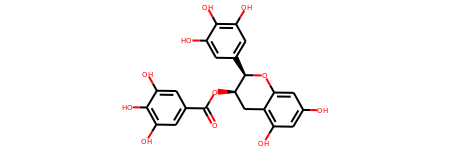

In [3]:
egcg_m = Chem.MolFromSmiles('O=C(O[C@@H]1Cc2c(O)cc(O)cc2O[C@@H]1c1cc(O)c(O)c(O)c1)c1cc(O)c(O)c(O)c1')
egcg_m

# Silybins

In [4]:
silyA = 'COc1cc([C@H]2Oc3cc([C@H]4Oc5cc(O)cc(O)c5C(=O)[C@@H]4O)ccc3O[C@@H]2CO)ccc1O'
silyB = 'COc1cc([C@@H]2Oc3cc([C@H]4Oc5cc(O)cc(O)c5C(=O)[C@@H]4O)ccc3O[C@H]2CO)ccc1O'

In [5]:
SilyA_m = Chem.MolFromSmiles(silyA)
SilyB_m = Chem.MolFromSmiles(silyB)

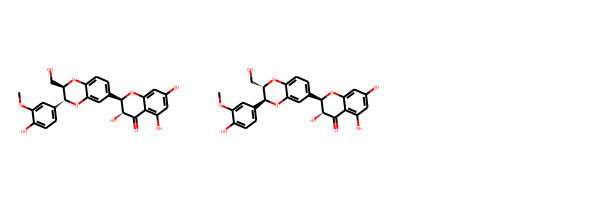

In [6]:
Draw.MolsToGridImage([SilyA_m, SilyB_m])

#### Generate conformers

In [7]:
egcg_confs, egcg_ids = generateconformations(m=egcg_m, n=2000, thresh=1.25,
    fname='parametrization_Juan/EGCG_confs.sdf', save=True)



In [8]:
silA_confs, silA_ids = generateconformations(m=SilyA_m, n=2000, thresh=1.5,
    fname='parametrization_Juan/SilybinA_confs.sdf', save=True)



In [9]:
silB_confs, silB_ids = generateconformations(m=SilyB_m, n=2000, thresh=1.5,
    fname='parametrization_Juan/SilybinB_confs.sdf', save=True)



## RMS matrix

In [8]:
def get_rms_matrix(m):
    Chem.RemoveHs(m)
    AllChem.AlignMolConformers(m)
    num_confs = m.GetNumConformers()
    rms_matrix = np.zeros(shape=(num_confs, num_confs))
    for id1 in range(num_confs):
        for id2 in range(num_confs):
            if id1 != id2:
                rms = AllChem.GetConformerRMS(m, id1, id2, prealigned=True)
                rms_matrix[id1][id2] = rms
    return rms_matrix

In [9]:
def plot_rms_matrix(m, rms_matrix=None, ax=None, triangle=True,
                    subplots_kwargs=None, heatmap_kwargs=None):

    if rms_matrix is None:
        rms_matrix = get_rms_matrix(m)
    if triangle:
        mask = np.zeros_like(rms_matrix, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True
    else:
        mask = None
    # Plot
    if subplots_kwargs is None:
        subplots_kwargs = {}
    if heatmap_kwargs is None:
        heatmap_kwargs = {}
    if ax is None:
        f, ax = plt.subplots(**subplots_kwargs)
    sns.heatmap(data=rms_matrix, ax=ax, mask=mask, **heatmap_kwargs)
    return rms_matrix, ax

### EGCG

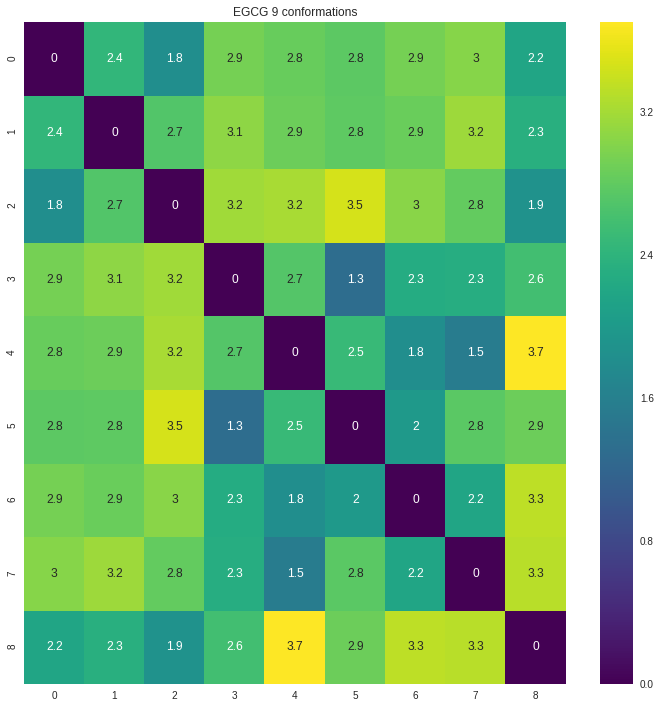

In [10]:
_, ax = plot_rms_matrix(egcg_confs,
                        triangle=False,
                        subplots_kwargs={'figsize':(10, 10)},
                        heatmap_kwargs={'cmap':'viridis', 'annot':True})
ax.set(title='EGCG %d conformations' % len(egcg_ids));
plt.tight_layout()
f = plt.gcf()
f.savefig('parametrization_Juan/egcg_%d_rms_mat.pdf' % len(egcg_ids))
f.savefig('parametrization_Juan/egcg_%d_rms_mat.png' % len(egcg_ids), dpi=300)

### Silybin A

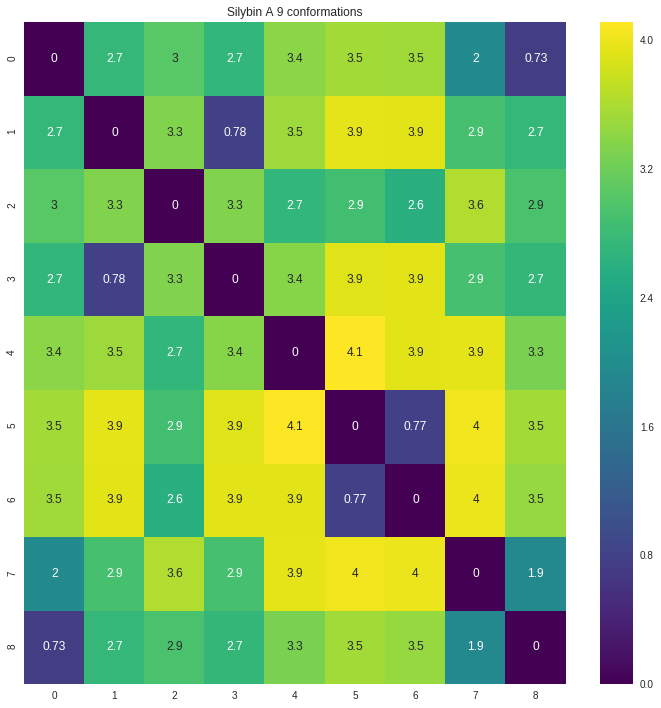

In [13]:
_, ax = plot_rms_matrix(silA_confs,
                        triangle=False,
                        subplots_kwargs={'figsize':(10, 10)},
                        heatmap_kwargs={'cmap':'viridis', 'annot':True})
ax.set(title='Silybin A %d conformations' % len(silA_ids));
plt.tight_layout()
f = plt.gcf()
f.savefig('parametrization_Juan/silA_%d_rms_mat.pdf' % len(silA_ids))
f.savefig('parametrization_Juan/silA_%d_rms_mat.png' % len(silA_ids), dpi=300)

### Silybin B

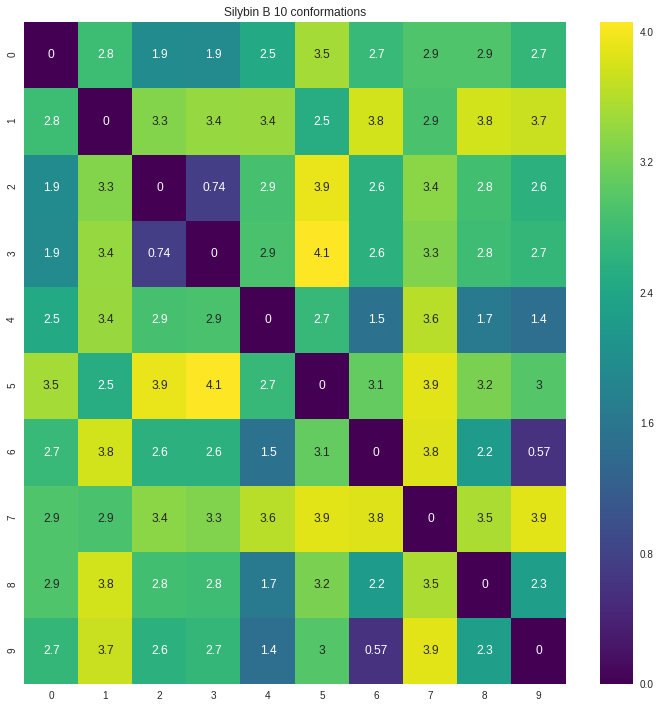

In [14]:
_, ax = plot_rms_matrix(silB_confs,
                        triangle=False,
                        subplots_kwargs={'figsize':(10, 10)},
                        heatmap_kwargs={'cmap':'viridis', 'annot':True})
ax.set(title='Silybin B %d conformations' % len(silB_ids));
plt.tight_layout()
f = plt.gcf()
f.savefig('parametrization_Juan/silB_%d_rms_mat.pdf' % len(silB_ids))
f.savefig('parametrization_Juan/silB_%d_rms_mat.png' % len(silB_ids), dpi=300)